In [1]:
## Packages
##Imports
import pandas as pd
import transformers
import openpyxl
import numpy
import torch
import os
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict
import time

import torch
import torch.nn as nn

# Does augmenting classifiers with structured data help?
# Do it for both the baseline classical ML and transformers then compare
# Try it with just structured data [0s and 1s]

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Ti'

In [4]:
## Reading in the PSYTar data set and parsing it

## Use sentence_labelling sheet

fileName=".\ONLINE_FORA\PsyTAR_dataset.xlsx"
data=pd.ExcelFile(fileName)
sheets={}
for sheet in data.sheet_names:
    sheets[sheet]=data.parse(sheet)

## Remove the first two sheets (License and read_me)
sheets.pop('License',None)
sheets.pop('read_me',None)

## This will print out the sheet names for the whole excel
for sheet in sheets.keys():
    print(f"Sheet Name: {sheet}")

#To access a sheet, perform sheet['Sheet_Name']; e.g., sheets['Sample']

Sheet Name: Sample
Sheet Name: Sentence_Labeling
Sheet Name: ADR_Identified
Sheet Name: ADR_Mapped
Sheet Name: WD_Identified
Sheet Name: WD-Mapped 
Sheet Name: SSI_Identified
Sheet Name: SSI_Mapped
Sheet Name: DI_Identified
Sheet Name: DI_Mapped


In [5]:
## Vectorize data into TF-IDF and preprocess data

import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer


def preprocess(text):
    text=str(text)
    tokens=nltk.word_tokenize(text.lower())
    tokens_clean=[t for t in tokens if (t not in stop_words) and (t not in punctuations)]
    return ' '.join(tokens_clean)
    
stop_words=nltk.corpus.stopwords.words('english')
punctuations=string.punctuation

df=data.parse('Sentence_Labeling')
df.drop(df.tail(1).index,inplace=True)
df['drug_id']=df['drug_id'].str.lower()
df['drug_name']=df['drug_id'].str.replace(r'\.\d+','',regex=True)
df['sentences']=df['sentences'].apply(preprocess)
df.fillna(0,inplace=True)
unique_drug_count=df['drug_name'].nunique()

tfidf=TfidfVectorizer()
tfidfSentences=tfidf.fit_transform(df['sentences'])

print(tfidfSentences)

print('Number of Drug Types:',unique_drug_count)
print(df)

## ADR: adverse drug reaction
## WD: withdrawal symptom
## EF: effective
## INF: ineffective
## SSI: Sign/symptom/illness - if report contains explicit SSI that patient experienced that are not a result of the drug
## DI: drug indication - shows SSI that explicitly mentioned as being resolved because of drug consumption

  (0, 2183)	0.3560733570424169
  (0, 2858)	0.5335210557775061
  (0, 2980)	0.33695305203929327
  (0, 4715)	0.3577130194209486
  (0, 4193)	0.36113778160835414
  (0, 2071)	0.2627216248356759
  (0, 5156)	0.2390135798252401
  (0, 1829)	0.30083291559032393
  (1, 2765)	0.4585168729312828
  (1, 1351)	0.8886857021677111
  (2, 2263)	0.2708094866549267
  (2, 4586)	0.4316846093641784
  (2, 5071)	0.44358904667953863
  (2, 4827)	0.2570546169681927
  (2, 3078)	0.23875893121623276
  (2, 4151)	0.3207489298964512
  (2, 1492)	0.29911785906957045
  (2, 1201)	0.35264280744022497
  (2, 4287)	0.3220996041881179
  (3, 4012)	0.534375375933816
  (3, 3326)	0.5729355939201095
  (3, 1018)	0.39488574070665183
  (3, 1237)	0.3054771887014283
  (3, 5)	0.3700495936825698
  (4, 4801)	0.3601630582861626
  :	:
  (6006, 3810)	0.266723700884449
  (6006, 278)	0.30278988091992165
  (6006, 4033)	0.24160419308016043
  (6006, 1558)	0.24160419308016043
  (6006, 2821)	0.21617383387506503
  (6006, 3470)	0.20987895271102364
  (6006,

In [6]:
# ## This is just the plain sentences -- Task 1 Feature 1
# from sklearn.model_selection import train_test_split

# df['DI'] = pd.to_numeric(df['DI'], errors='coerce')

# newDf=df
# newDf['DI'].fillna(0, inplace=True)
# newDf.drop(columns=["id", "comment_id", "drug_id", "sentence_index", "Findings", "others", "rating", "category","drug_name"], axis=1, inplace=True)

# # x = df['sentences'].values
# # y = df[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
# # y = np.nan_to_num(y, nan=0).astype(int)

# df_train, df_test = train_test_split(newDf, random_state=42, test_size=0.10, shuffle=True)
# # split test into test and validation datasets
# df_test, df_valid = train_test_split(newDf, random_state=42, test_size=0.50, shuffle=True)


In [7]:
# This one uses the drug_name with the sentences -- Task 1 Feature 2

from sklearn.model_selection import train_test_split

df['DI'] = pd.to_numeric(df['DI'], errors='coerce')
newDf=df
newDf['DI'].fillna(0, inplace=True)
newDf['drug_sentences'] = df['drug_name'] + ' ' + df['sentences']
newDf.drop(columns=["id", "comment_id", "drug_id", "sentence_index", "Findings", "others", "rating", "category","drug_name","sentences"], axis=1, inplace=True)
# x = df['drug_sentences'].values
# y = df[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values
# y = np.nan_to_num(y, nan=0).astype(int)

df_train, df_test = train_test_split(newDf, random_state=42, test_size=0.10, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(newDf, random_state=42, test_size=0.50, shuffle=True)


C:\Users\julev\AppData\Local\Temp\ipykernel_21368\2523967935.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  newDf['DI'].fillna(0, inplace=True)


In [8]:
print(newDf)

      ADR   WD   EF  INF  SSI   DI  \
0     1.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  1.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...   
6004  0.0  0.0  0.0  0.0  0.0  0.0   
6005  0.0  0.0  0.0  0.0  0.0  0.0   
6006  0.0  0.0  0.0  0.0  0.0  0.0   
6007  0.0  0.0  1.0  0.0  0.0  0.0   
6008  0.0  0.0  1.0  0.0  0.0  0.0   

                                         drug_sentences  
0     lexapro extreme weight gain short-term memory ...  
1                              lexapro detoxing lexapro  
2     lexapro slowly cut dosage several months took ...  
3                  lexapro 10 days completely omg rough  
4     lexapro flu-like symptoms dizziness major mood...  
...                                                 ...  
6004                      effexorxr increase dosage yet  
6005  effexorxr 'm hoping able stay 75 mgs long poss...  
6006  effexorxr readi

In [9]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (5408, 7), Test: (3004, 7), Valid: (3005, 7)


In [10]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
EPOCHS = 15
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

In [11]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
#df_train['sentences']

In [13]:
class CustomDatasetTask1(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['sentences'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }
     
     
class CustomDatasetTask2(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['drug_sentences'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }
     

In [14]:
target_list = list(['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI'])
target_list

['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']

In [15]:
#change this to CustomDatasetTask_ for feature _
train_dataset = CustomDatasetTask2(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDatasetTask2(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDatasetTask2(df_test, tokenizer, MAX_LEN, target_list)

In [16]:
next(iter(train_dataset))

{'input_ids': tensor([  101, 17244,  9331,  3217,  4318,  2677, 15311,  3806,  1038,  4135,
          5844,  3356,  2067, 12336,  2926,  2305, 18856,  3286,  8029,  3110,
         14978,  6091,  2791,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [17]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)
     

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [19]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [20]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)    

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [22]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

In [23]:
torch.cuda.empty_cache()
history = defaultdict(list)
best_accuracy = 0

model_save_path = './model2_task1_feature2_model(unfrozen)'
start_time = time.time()

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        if not os.path.exists(model_save_path):
            os.makedirs(model_save_path)
        torch.save(model.state_dict(), os.path.join(model_save_path, 'model_state.bin'))
        print(f"Model saved to {model_save_path}")
        best_accuracy = val_acc
         
end_time = time.time()
total_train_time = end_time - start_time

print(f"Total training time: {total_train_time:.2f} seconds")
torch.cuda.empty_cache()

Epoch 1/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.3293, val_loss=0.2369 train_acc=0.8716, val_acc=0.9134
Model saved to ./model2_task1_feature2_model(unfrozen)
Epoch 2/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.2300, val_loss=0.1778 train_acc=0.9148, val_acc=0.9369
Model saved to ./model2_task1_feature2_model(unfrozen)
Epoch 3/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.1845, val_loss=0.1451 train_acc=0.9335, val_acc=0.9491
Model saved to ./model2_task1_feature2_model(unfrozen)
Epoch 4/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.1470, val_loss=0.1148 train_acc=0.9484, val_acc=0.9632
Model saved to ./model2_task1_feature2_model(unfrozen)
Epoch 5/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.1135, val_loss=0.1047 train_acc=0.9616, val_acc=0.9673
Model saved to ./model2_task1_feature2_model(unfrozen)
Epoch 6/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.0857, val_loss=0.0864 train_acc=0.9728, val_acc=0.9749
Model saved to ./model2_task1_feature2_model(unfrozen)
Epoch 7/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.0651, val_loss=0.0800 train_acc=0.9795, val_acc=0.9771
Model saved to ./model2_task1_feature2_model(unfrozen)
Epoch 8/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.0520, val_loss=0.0768 train_acc=0.9833, val_acc=0.9781
Model saved to ./model2_task1_feature2_model(unfrozen)
Epoch 9/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.0397, val_loss=0.0740 train_acc=0.9875, val_acc=0.9788
Model saved to ./model2_task1_feature2_model(unfrozen)
Epoch 10/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.0328, val_loss=0.0728 train_acc=0.9902, val_acc=0.9813
Model saved to ./model2_task1_feature2_model(unfrozen)
Epoch 11/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.0250, val_loss=0.0769 train_acc=0.9921, val_acc=0.9806
Epoch 12/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.0213, val_loss=0.0729 train_acc=0.9934, val_acc=0.9826
Model saved to ./model2_task1_feature2_model(unfrozen)
Epoch 13/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.0173, val_loss=0.0717 train_acc=0.9950, val_acc=0.9835
Model saved to ./model2_task1_feature2_model(unfrozen)
Epoch 14/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.0138, val_loss=0.0746 train_acc=0.9963, val_acc=0.9840
Model saved to ./model2_task1_feature2_model(unfrozen)
Epoch 15/15


  0%|          | 0/676 [00:00<?, ?it/s]

train_loss=0.0115, val_loss=0.0772 train_acc=0.9970, val_acc=0.9834
Total training time: 2037.76 seconds


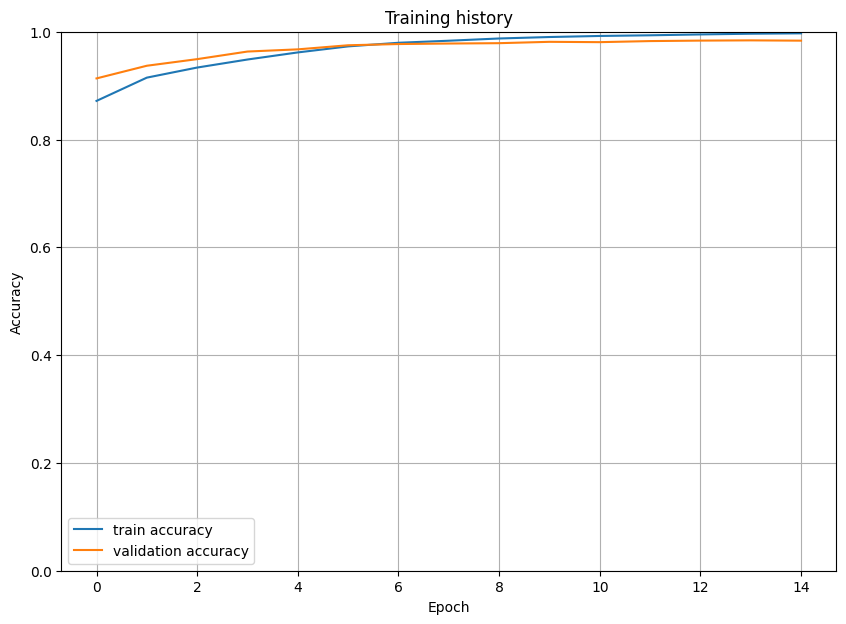

In [24]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

In [25]:
torch.cuda.empty_cache()

In [26]:
# Loading pretrained model (best model)
model_load_path = './model2_task1_feature2_model(unfrozen)'
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(model_load_path, 'model_state.bin')))
model = model.to(device)

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [27]:
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [28]:
test_acc

0.9982800710164226

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
     
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return titles, predictions, prediction_probs, target_values

In [30]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [31]:
predictions.numpy()

array([[0., 0., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [32]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:3004 
predictions:torch.Size([3004, 6]) 
prediction_probs:torch.Size([3004, 6]) 
target_values:torch.Size([3004, 6])


In [33]:
print(classification_report(target_values, predictions, target_names=target_list))

              precision    recall  f1-score   support

         ADR       1.00      1.00      1.00      1081
          WD       0.99      0.99      0.99       215
          EF       0.99      1.00      0.99       576
         INF       0.98      0.98      0.98       175
         SSI       1.00      0.99      1.00       386
          DI       0.99      0.99      0.99       255

   micro avg       0.99      0.99      0.99      2688
   macro avg       0.99      0.99      0.99      2688
weighted avg       0.99      0.99      0.99      2688
 samples avg       0.65      0.65      0.65      2688



c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
